# 1. Setting up the environment
In this cell, we will install PyTorch, Torchvision, and the necessary supporting libraries.

In [2]:
!pip install torch torchvision matplotlib opencv-python pillow torchmetrics tqdm

# 2. Import the necessary libraries:
Including PyTorch, Torchvision, and modules to support training, inference, and visualization.

In [3]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import os
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm

# 3. Upload dataset from Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
ROOT = "/content/drive/MyDrive/projects/RnD-FSPDforAI"

# 4. Define Dataset class
The Dataset will read images and annotations (bounding boxes) from the directory.
The assumed annotation is in `.txt` format: x1 y1 x2 y2 class_id

In [5]:
class AerialDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "annotations"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        ann_path = os.path.join(self.root, "annotations", self.annotations[idx])

        img = Image.open(img_path).convert("RGB")

        # Get image dimensions for bounding box validation
        img_width, img_height = img.size

        boxes_list, labels_list = self.parse_annotation(ann_path, img_width, img_height)

        # Handle cases where no valid bounding boxes are found for an image
        if len(boxes_list) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes_list, dtype=torch.float32)
            labels = torch.as_tensor(labels_list, dtype=torch.int64)
            # Calculate area for each bounding box
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(boxes_list),), dtype=torch.int64) # All instances are not crowd

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx]) # image_id should be unique for each image
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def parse_annotation(self, ann_path, img_width, img_height):
        boxes, labels = [], []
        try:
            with open(ann_path) as f:
                for line in f:
                    try:
                        x1_str, y1_str, x2_str, y2_str, cls_str = line.strip().split()
                        x1, y1, x2, y2 = float(x1_str), float(y1_str), float(x2_str), float(y2_str)
                        cls = int(cls_str)

                        # Basic validation for bounding box coordinates
                        # - Coordinates must be within image bounds
                        # - x1 < x2, y1 < y2
                        # - All coordinates must be non-negative
                        if not (0 <= x1 < x2 <= img_width and 0 <= y1 < y2 <= img_height):
                            print(f"Warning: Invalid bounding box coordinates in {ann_path} for image size ({img_width}, {img_height}): {line.strip()}. Skipping.")
                            continue

                        boxes.append([x1, y1, x2, y2])
                        labels.append(cls)
                    except ValueError:
                        print(f"Warning: Malformed line in {ann_path}: {line.strip()}. Skipping.")
                        continue
        except FileNotFoundError:
            print(f"Warning: Annotation file not found: {ann_path}. Assuming no objects for this image.")
        return boxes, labels

# 5. Defining the Faster R-CNN model
Using pretrained Faster R-CNN on COCO.

In [6]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# 6. Model Training
Train a few epochs on a small subset to illustrate.

In [7]:
def get_num_classes(dataset_root, annotation_files):
    """
    Dynamically determines the number of classes from annotation files.
    The number of classes is max_label_id + 1 (for background).
    """
    max_label_id = -1
    ann_folder = os.path.join(dataset_root, "annotations")

    for ann_file in annotation_files:
        ann_path = os.path.join(ann_folder, ann_file)

        if not os.path.exists(ann_path):
            continue

        with open(ann_path) as f:
            for line in f:
                try:
                    parts = line.strip().split()
                    # Must include x1, y1, x2, y2, cls (5 parts)
                    if len(parts) == 5:
                        cls_str = parts[4]
                        max_label_id = max(max_label_id, int(cls_str))
                except ValueError:
                    pass

    if max_label_id < 1: # If cannot find any labels (max_label_id = -1) or labels start from 0
        num_classes = 2 # Default 1 background + 1 foreground
        print(f"Warning: Detected maximum class ID: {max_label_id}. Defaulting num_classes to 2.")
    else:
        # Faster R-CNN: K foreground classes (1..K) + 1 background class (0) = K+1
        num_classes = max_label_id + 1

    return num_classes

In [8]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, num_epochs):
    model.train()

    pbar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    running_loss = 0.0

    for i, (images, targets) in enumerate(pbar):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Cal loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation and update
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Update avg loss
        running_loss += losses.item()

        pbar.set_postfix({'batch_loss': f'{losses.item():.4f}',
                          'avg_loss': f'{running_loss / (i+1):.4f}'})

    epoch_loss = running_loss / len(data_loader)

    return epoch_loss

In [9]:
def train_model(train_root, num_epochs=20, lr=0.005, batch_size=4, save_dir=ROOT):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device use: {device}")

    # Prepare data
    dataset = AerialDataset(root=train_root, transforms=torchvision.transforms.ToTensor())

    # Determine the number of classes
    num_classes = get_num_classes(dataset.root, dataset.annotations)
    print(f"Detected maximum class ID: {num_classes - 1}")
    print(f"Setting num_classes for Faster R-CNN to: {num_classes} (background included)")

    # Create Data loader
    data_loader = DataLoader(dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             collate_fn=lambda x: tuple(zip(*x)))

    # Initializing the model, optimizer, and scheduler
    model = get_model(num_classes=num_classes)
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train loop
    print(f"\nStart training with {num_epochs} epochs...")

    for epoch in range(num_epochs):
        # Train 1 epoch and get epoch loss
        epoch_loss = train_one_epoch(model, optimizer, data_loader, device, epoch, num_epochs)

        # Update learning rate
        lr_scheduler.step()

        current_lr = optimizer.param_groups[0]['lr']
        print(f"--- Epoch {epoch+1} finished. Avg loss: {epoch_loss:.4f} ---\n")

    # --- 7. Lưu Mô hình ---
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "fasterrcnn_aerial.pth")
    torch.save(model.state_dict(), save_path)
    print(f"The model is saved at: {save_path}")

    return model, num_classes

In [10]:
TRAIN_ROOT = os.path.join(ROOT, "dataset", "train")
NUM_EPOCHS = 20
BATCH_SIZE = 4
SAVE_DIR = os.path.join(ROOT, "model")

model, num_classes = train_model(
    train_root=TRAIN_ROOT,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    save_dir=SAVE_DIR
)

Device use: cpu
Detected maximum class ID: 4
Setting num_classes for Faster R-CNN to: 5 (background included)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Start training with 20 epochs...


Epoch 1/20: 100%|██████████| 2/2 [02:56<00:00, 88.40s/it, batch_loss=1.8721, avg_loss=4.6775]


--- Epoch 1 finished. Avg loss: 4.6775 ---



Epoch 2/20: 100%|██████████| 2/2 [02:38<00:00, 79.27s/it, batch_loss=1.5497, avg_loss=1.8345]


--- Epoch 2 finished. Avg loss: 1.8345 ---



Epoch 3/20: 100%|██████████| 2/2 [03:11<00:00, 95.80s/it, batch_loss=2.2167, avg_loss=2.1331]


--- Epoch 3 finished. Avg loss: 2.1331 ---



Epoch 4/20: 100%|██████████| 2/2 [03:06<00:00, 93.43s/it, batch_loss=1.8447, avg_loss=2.1329]


--- Epoch 4 finished. Avg loss: 2.1329 ---



Epoch 5/20: 100%|██████████| 2/2 [02:32<00:00, 76.20s/it, batch_loss=1.5306, avg_loss=1.8543]


--- Epoch 5 finished. Avg loss: 1.8543 ---



Epoch 6/20: 100%|██████████| 2/2 [03:03<00:00, 91.70s/it, batch_loss=1.9225, avg_loss=1.7993]


--- Epoch 6 finished. Avg loss: 1.7993 ---



Epoch 7/20: 100%|██████████| 2/2 [03:03<00:00, 91.72s/it, batch_loss=1.5787, avg_loss=1.6157]


--- Epoch 7 finished. Avg loss: 1.6157 ---



Epoch 8/20: 100%|██████████| 2/2 [02:31<00:00, 75.72s/it, batch_loss=1.4494, avg_loss=1.7032]


--- Epoch 8 finished. Avg loss: 1.7032 ---



Epoch 9/20: 100%|██████████| 2/2 [03:07<00:00, 93.99s/it, batch_loss=1.4791, avg_loss=1.7389]


--- Epoch 9 finished. Avg loss: 1.7389 ---



Epoch 10/20: 100%|██████████| 2/2 [02:42<00:00, 81.32s/it, batch_loss=1.4171, avg_loss=1.5703]


--- Epoch 10 finished. Avg loss: 1.5703 ---



Epoch 11/20: 100%|██████████| 2/2 [03:05<00:00, 92.78s/it, batch_loss=1.6134, avg_loss=1.5574]


--- Epoch 11 finished. Avg loss: 1.5574 ---



Epoch 12/20: 100%|██████████| 2/2 [03:04<00:00, 92.50s/it, batch_loss=2.4592, avg_loss=1.8647]


--- Epoch 12 finished. Avg loss: 1.8647 ---



Epoch 13/20: 100%|██████████| 2/2 [02:45<00:00, 82.56s/it, batch_loss=1.0939, avg_loss=1.3153]


--- Epoch 13 finished. Avg loss: 1.3153 ---



Epoch 14/20: 100%|██████████| 2/2 [03:02<00:00, 91.24s/it, batch_loss=1.4158, avg_loss=1.4114]


--- Epoch 14 finished. Avg loss: 1.4114 ---



Epoch 15/20: 100%|██████████| 2/2 [03:06<00:00, 93.47s/it, batch_loss=1.3113, avg_loss=1.3401]


--- Epoch 15 finished. Avg loss: 1.3401 ---



Epoch 16/20: 100%|██████████| 2/2 [03:05<00:00, 92.93s/it, batch_loss=1.2946, avg_loss=1.3392]


--- Epoch 16 finished. Avg loss: 1.3392 ---



Epoch 17/20: 100%|██████████| 2/2 [02:48<00:00, 84.00s/it, batch_loss=1.0336, avg_loss=1.2345]


--- Epoch 17 finished. Avg loss: 1.2345 ---



Epoch 18/20: 100%|██████████| 2/2 [03:04<00:00, 92.46s/it, batch_loss=1.1932, avg_loss=1.3159]


--- Epoch 18 finished. Avg loss: 1.3159 ---



Epoch 19/20: 100%|██████████| 2/2 [02:43<00:00, 81.62s/it, batch_loss=1.4684, avg_loss=1.3977]


--- Epoch 19 finished. Avg loss: 1.3977 ---



Epoch 20/20: 100%|██████████| 2/2 [03:11<00:00, 95.67s/it, batch_loss=1.9781, avg_loss=1.5898]


--- Epoch 20 finished. Avg loss: 1.5898 ---

The model is saved at: /content/drive/MyDrive/projects/RnD-FSPDforAI/model/fasterrcnn_aerial.pth


# 7. Evaluating the model on the test set using mAP

In [11]:
def evaluate(model, dataset_test, device):
    model.to(device)
    data_loader_test = DataLoader(dataset_test, batch_size=2, collate_fn=lambda x: tuple(zip(*x)))

    metric = MeanAveragePrecision(box_format='xyxy')
    model.eval()

    with torch.no_grad():
        for images, targets in data_loader_test:
            images = [img.to(device) for img in images]
            preds = model(images)
            preds_cpu = [{k: v.cpu() for k, v in t.items()} for t in preds]
            metric.update(preds, targets)

    result = metric.compute()
    return result

In [12]:
dataroot = os.path.join(ROOT, "dataset", "test")
dataset_test = AerialDataset(root=dataroot, transforms=torchvision.transforms.ToTensor())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
result = evaluate(model, dataset_test, device)
result

{'map': tensor(0.1172),
 'map_50': tensor(0.2408),
 'map_75': tensor(0.0704),
 'map_small': tensor(0.0413),
 'map_medium': tensor(0.2201),
 'map_large': tensor(0.0010),
 'mar_1': tensor(0.0021),
 'mar_10': tensor(0.0172),
 'mar_100': tensor(0.1310),
 'mar_small': tensor(0.0435),
 'mar_medium': tensor(0.2432),
 'mar_large': tensor(0.0048),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([1, 3, 4], dtype=torch.int32)}

# 8. Inference and Visualization
Dùng mô hình đã huấn luyện để dự đoán bounding box trên ảnh test và hiển thị kết quả.

In [20]:
ID_TO_CLASS = {
    1: 'plane',
    2: 'ship',
    3: 'large-vehicle',
    4: 'small-vehicle'
}

def inference(image_path, num_classes, model_path="fasterrcnn_aerial.pth", score_threshold=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_model(num_classes=num_classes)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        print(f"Error: Weight file not found at {model_path}. Please check again.")
        return

    model.eval().to(device)

    try:
        image = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}. Please check again.")
        return

    transform = torchvision.transforms.ToTensor()
    img_tensor = transform(image).to(device)

    with torch.no_grad():
        prediction = model([img_tensor])

    boxes = prediction[0]['boxes'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    img_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    for box, score, label in zip(boxes, scores, labels):
        if score > score_threshold:
            x1, y1, x2, y2 = box.astype(int)
            class_name = ID_TO_CLASS.get(label, f"Unknown ({label})")
            text_to_display = f"{class_name} ({score:.2f})"
            cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(img_cv, text_to_display, (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


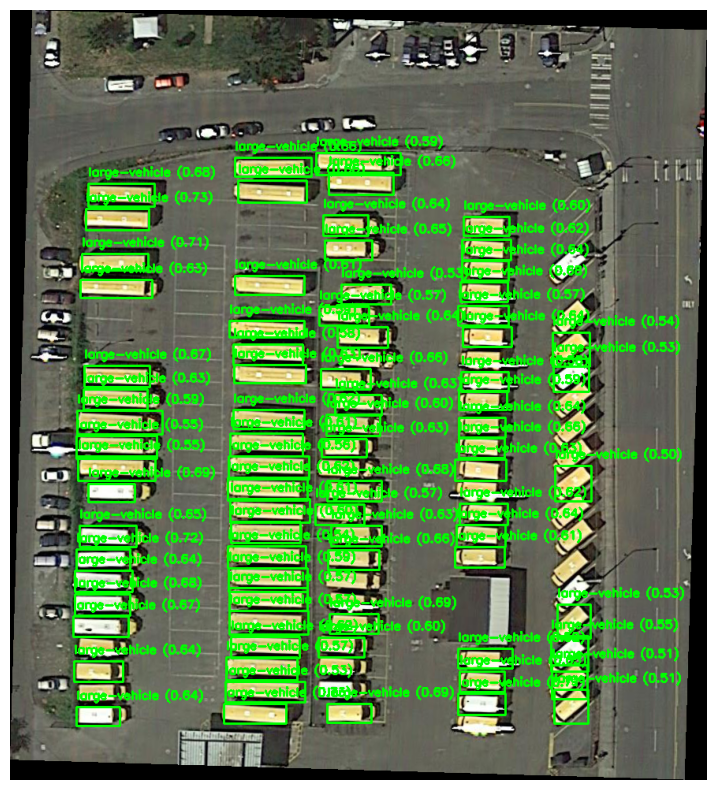

In [24]:
IMAGE_PATH = TRAIN_ROOT = os.path.join(ROOT, "dataset/test/images/P0005.png")
NUM_CLASSES = num_classes

MODEL_PATH = TRAIN_ROOT = os.path.join(ROOT, "model/fasterrcnn_aerial.pth")

result = inference(IMAGE_PATH, NUM_CLASSES, MODEL_PATH)